<a href="https://colab.research.google.com/github/louisowen6/NLP_Stacking_Ensemble/blob/master/CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount the Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Import Packages

In [0]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gensim 
import nltk
from time import time
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics.pairwise import cosine_similarity

# Run it to obtain reproducible results across machines (from keras.io)
from __future__ import print_function
import tensorflow as tf
import random as rn
import os
from tensorflow.keras import optimizers,backend as K
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Dense, Dropout, Embedding,Conv1D,GlobalMaxPooling1D,Concatenate,GaussianNoise,LSTM,BatchNormalization

# Import Supporting Files

In [0]:
#Google Word2Vec Pretrained Model
link ='https://drive.google.com/open?id=16A169DxZ-h9qU0i6rXCoSh_djkBWnd9V'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('GoogleNews-vectors-negative300.bin')   
model_w2v = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

#GloVe Pretrained Model
link ='https://drive.google.com/open?id=1p1IN9O_fpSQzPTFB5Y8CCOMXPIPU1WGV'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('glove.twitter.27B.200d.txt')   
def loadGloveModel(gloveFilePath):
    print("Loading Glove Model")
    f = open(gloveFilePath,'r',encoding='utf-8')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model
model_GloVe=loadGloveModel('glove.twitter.27B.200d.txt')

16A169DxZ-h9qU0i6rXCoSh_djkBWnd9V


# Import Data

In [0]:
link ='https://drive.google.com/open?id=19nc79hUNZP0xH2IssgSQQTWxNjqAQZnT'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_train_final.csv')  
df_train = pd.read_csv('df_train_final.csv')
df_train=df_train.drop(['Unnamed: 0','index'],1)

link ='https://drive.google.com/open?id=1cDKGfay0oLkGQM0jz4nyk6c9CoE2YIpi'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('df_test_final.csv')  
df_test = pd.read_csv('df_test_final.csv')
df_test=df_test.drop(['Unnamed: 0','index'],1)

19nc79hUNZP0xH2IssgSQQTWxNjqAQZnT
1cDKGfay0oLkGQM0jz4nyk6c9CoE2YIpi


# CNN

In [0]:
t = Tokenizer()
text_lst=['Mathematics is Fun','Especially Linear Algebra']
print('Corpus: {}'.format(text_lst))
t.fit_on_texts(text_lst)
print('Word index: {}'.format(t.word_index))
new_text=['Linear algebra is Mathematics']
print('Input New text: {}'.format(new_text[0]))
a=t.texts_to_sequences(new_text)
print('New text index sequences: {}'.format(a))
print('Padding with maximum length equal 10: {}'.format(pad_sequences(a, padding='post', maxlen=10)))

Corpus: ['Mathematics is Fun', 'Especially Linear Algebra']
Word index: {'mathematics': 1, 'is': 2, 'fun': 3, 'especially': 4, 'linear': 5, 'algebra': 6}
Input New text: Linear algebra is Mathematics
New text index sequences: [[5, 6, 2, 1]]
Padding with maximum length equal 10: [[5 6 2 1 0 0 0 0 0 0]]


## W2V

### Hyperparameter Tuning

In [0]:
def grid_model_W2V(df,input_noise,hidden_dropout,activation_conv_list,activation_list,hidden_nodes_1,hidden_nodes_2,optimizer,epochs):
  '''
  Function for hyperparameter tuning W2V embedding
  '''
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=500)
  X=df['clean_text']
  stratify=df['source']
  y=df['sentiment score']
  max_sequence_length = 50
  for act_conv in activation_conv_list:
    for act in activation_list:
      cvscores = []
      start=time()
      for train,val in kfold.split(X,stratify):
        X_train=X[train].tolist()
        y_train=np.array(y[train])
        X_val=X[val].tolist()
        y_val=np.array(y[val])

        # prepare tokenizer
        t = Tokenizer()
        t.fit_on_texts(X_train)
        X_train = t.texts_to_sequences(X_train)
        X_val = t.texts_to_sequences(X_val)

        # Adding 1 because of reserved 0 index
        vocab_size = len(t.word_index) + 1

        X_train = pad_sequences(X_train, padding='post', maxlen=max_sequence_length)
        X_val = pad_sequences(X_val, padding='post', maxlen=max_sequence_length)

        embedding_size=300
        # create a weight matrix for words in training docs
        W2V_embedding_matrix = np.zeros((vocab_size, embedding_size))
        for word, i in t.word_index.items():
          if word in model_w2v:
            W2V_embedding_vector = model_w2v[word]
            W2V_embedding_matrix[i] = W2V_embedding_vector
      
        #Define Multiple Filter Sizes
        submodels = []
        embedding_layer = Embedding(vocab_size, embedding_size, weights=[W2V_embedding_matrix], input_length=max_sequence_length, trainable=False)
        sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
        for kw in (1,2,3,4):    # kernel sizes
            embedded_sequences = embedding_layer(sequence_input)
            sub=GaussianNoise(input_noise)(embedded_sequences)
            sub_submodels=[]
            for i in range(25):
              subsub=BatchNormalization()(sub)
              subsub=Conv1D(1,kw,padding='valid',activation=act_conv,strides=1)(sub)
              subsub=GlobalMaxPooling1D()(subsub)
              subsubmodel=Model(sequence_input,subsub)
              sub_submodels.append(subsubmodel)
            sub_submodel_outputs=[subsubmodel.output for subsubmodel in sub_submodels]
            sub_out=Concatenate(axis=1)(sub_submodel_outputs)
            submodel=Model(sequence_input,sub_out)
            submodels.append(submodel)

        #Concatenate Multiple Filter Sizes
        submodel_outputs = [submodel.output for submodel in submodels]
        out = Concatenate(axis=1)(submodel_outputs)
        out = Dropout(hidden_dropout)(out)
        out = Dense(hidden_nodes_1,activation=act,use_bias=True,bias_initializer='glorot_uniform')(out)
        out = Dense(hidden_nodes_2,activation='tanh',use_bias=True,bias_initializer='glorot_uniform')(out)
        out = Dense(1)(out)
        big_model = Model(sequence_input,out)
        big_model.compile(loss='MSE', optimizer=optimizer, metrics=['cosine_proximity'])
        # print(big_model.summary())
        big_model.fit(X_train,y_train, batch_size=32,epochs=epochs, validation_data=(X_val, y_val),verbose=True)
        plt.figure(figsize=(6,6))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.ylim((0,0.25))
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        loss, cos = model.evaluate(X_val, y_val, verbose=False)
        print('Cosine Similarity: {}\n'.format(cos))
        cvscores.append(cos)
      end=time()
      print('Time Elapsed: {}'.format(end-start))
      print('Epochs: {}'.format(epochs))
      print('Optimizer: {}'.format(optimizer))
      print('Convolutional Activation Function: {}'.format(act_conv))
      print('Dense Activation Function: {}'.format(act))
      print('Hidden Nodes 1: {}'.format(hidden_nodes_1))
      print('Hidden Nodes 2: {}'.format(hidden_nodes_2))
      print('Input Noise Std: {}'.format(input_noise))
      print('Hidden Dropout Rate: {}'.format(hidden_dropout))
      print('Stratified k-Fold Cosine Similarity Avg Score: {}, Std Score: {}'.format(np.mean(cvscores),np.std(cvscores)))

In [0]:
adam=tensorflow.keras.optimizers.Adam(learning_rate=0.0005)
grid_model_W2V(df_train,input_noise=0.01,hidden_dropout=0.35,activation_conv_list=['tanh'],activation_list=['tanh'],hidden_nodes_1=10,hidden_nodes_2=5,epochs=15,optimizer=adam)

Train on 1046 samples, validate on 117 samples
Epoch 1/15
1046/1046 [==============================] - 40s 39ms/sample - loss: 0.4796 - cosine_proximity: 0.0153 - val_loss: 0.1671 - val_cosine_proximity: 0.1624
Epoch 2/15
1046/1046 [==============================] - 4s 4ms/sample - loss: 0.2404 - cosine_proximity: 0.1511 - val_loss: 0.1493 - val_cosine_proximity: 0.3162
Epoch 3/15
1046/1046 [==============================] - 4s 4ms/sample - loss: 0.1669 - cosine_proximity: 0.2658 - val_loss: 0.1420 - val_cosine_proximity: 0.2991
Epoch 4/15
1046/1046 [==============================] - 4s 4ms/sample - loss: 0.1532 - cosine_proximity: 0.3212 - val_loss: 0.1351 - val_cosine_proximity: 0.3162
Epoch 5/15
1046/1046 [==============================] - 4s 4ms/sample - loss: 0.1240 - cosine_proximity: 0.4092 - val_loss: 0.1275 - val_cosine_proximity: 0.3333
Epoch 6/15
1046/1046 [==============================] - 4s 4ms/sample - loss: 0.1101 - cosine_proximity: 0.4584 - val_loss: 0.1225 - val_cosi

### Prediction

In [0]:
def model_W2V(df,df_test,input_noise,hidden_dropout,act_conv,act,hidden_nodes_1,hidden_nodes_2,optimizer,epochs):
  '''
  Function for prediction
  '''
  X_train=df['clean_text'].tolist()
  y_train=np.array(df['sentiment score'])
  X_test=df_test['clean_text'].tolist()
  y_test=np.array(df_test['sentiment score'])
  max_sequence_length = 50
  start=time()

  # prepare tokenizer
  t = Tokenizer()
  t.fit_on_texts(X_train)
  X_train = t.texts_to_sequences(X_train)
  X_test = t.texts_to_sequences(X_test)

  # Adding 1 because of reserved 0 index
  vocab_size = len(t.word_index) + 1

  X_train = pad_sequences(X_train, padding='post', maxlen=max_sequence_length)
  X_test = pad_sequences(X_test, padding='post', maxlen=max_sequence_length)

  embedding_size=300
  # create a weight matrix for words in training docs
  W2V_embedding_matrix = np.zeros((vocab_size, embedding_size))
  for word, i in t.word_index.items():
    if word in model_w2v:
      W2V_embedding_vector = model_w2v[word]
      W2V_embedding_matrix[i] = W2V_embedding_vector
      
  #Define Multiple Filter Sizes
  submodels = []
  embedding_layer = Embedding(vocab_size, embedding_size, weights=[W2V_embedding_matrix], input_length=max_sequence_length, trainable=False)
  sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
  for kw in (1,2,3,4):    # kernel sizes
      embedded_sequences = embedding_layer(sequence_input)
      sub=GaussianNoise(input_noise)(embedded_sequences)
      sub_submodels=[]
      for i in range(25):
        subsub=BatchNormalization()(sub)
        subsub=Conv1D(1,kw,padding='valid',activation=act_conv,strides=1)(sub)
        subsub=GlobalMaxPooling1D()(subsub)
        subsubmodel=Model(sequence_input,subsub)
        sub_submodels.append(subsubmodel)
      sub_submodel_outputs=[subsubmodel.output for subsubmodel in sub_submodels]
      sub_out=Concatenate(axis=1)(sub_submodel_outputs)
      submodel=Model(sequence_input,sub_out)
      submodels.append(submodel)

  #Concatenate Multiple Filter Sizes
  submodel_outputs = [submodel.output for submodel in submodels]
  out = Concatenate(axis=1)(submodel_outputs)
  out = Dropout(hidden_dropout)(out)
  out = Dense(hidden_nodes_1,activation=act,use_bias=True,bias_initializer='glorot_uniform')(out)
  out = Dense(hidden_nodes_2,activation='tanh',use_bias=True,bias_initializer='glorot_uniform')(out)
  out = Dense(1)(out)
  big_model = Model(sequence_input,out)
  big_model.compile(loss='MSE', optimizer=optimizer, metrics=['cosine_proximity'])
  # print(big_model.summary())
  big_model.fit(X_train,y_train, batch_size=32,epochs=epochs,verbose=True)
  pred_test=big_model.predict(X_test,batch_size=32)
  pred_test=pred_test.reshape(1,-1)
  end=time()
  print('Time Elapsed: {}'.format(end-start))
  print('Epochs: {}'.format(epochs))
  print('Optimizer: {}'.format(optimizer))
  print('Convolutional Activation Function: {}'.format(act_conv))
  print('Dense Activation Function: {}'.format(act))
  print('Hidden Nodes 1: {}'.format(hidden_nodes_1))
  print('Hidden Nodes 2: {}'.format(hidden_nodes_2))
  print('Input Noise Std: {}'.format(input_noise))
  print('Hidden Dropout Rate: {}'.format(hidden_dropout))
  print('Test Cosine Similarity Score:{}'.format(cosine_similarity(pred_test,y_test.reshape(1,-1))[0][0]))
  return(pd.Series(pred_test[0]))

In [0]:
adam=tensorflow.keras.optimizers.Adam(learning_rate=0.0005)
pred_CNN_W2V=model_W2V(df_train,df_test,input_noise=0.01,hidden_dropout=0.35,act_conv='tanh',act='tanh',hidden_nodes_1=10,hidden_nodes_2=5,optimizer=adam,epochs=15)

Train on 1163 samples
Epoch 1/15
1163/1163 [==============================] - 6s 5ms/sample - loss: 0.1681 - cosine_proximity: 0.1969
Epoch 2/15
1163/1163 [==============================] - 2s 2ms/sample - loss: 0.1276 - cosine_proximity: 0.3345
Epoch 3/15
1163/1163 [==============================] - 2s 2ms/sample - loss: 0.1066 - cosine_proximity: 0.4927
Epoch 4/15
1163/1163 [==============================] - 2s 2ms/sample - loss: 0.0883 - cosine_proximity: 0.5976
Epoch 5/15
1163/1163 [==============================] - 2s 2ms/sample - loss: 0.0768 - cosine_proximity: 0.6217
Epoch 6/15
1163/1163 [==============================] - 2s 2ms/sample - loss: 0.0666 - cosine_proximity: 0.7145
Epoch 7/15
1163/1163 [==============================] - 2s 2ms/sample - loss: 0.0589 - cosine_proximity: 0.7369
Epoch 8/15
1163/1163 [==============================] - 2s 2ms/sample - loss: 0.0502 - cosine_proximity: 0.7661
Epoch 9/15
1163/1163 [==============================] - 2s 2ms/sample - loss: 0.04

In [0]:
pd.DataFrame(pred_CNN_W2V,columns=['pred_CNN_W2V']).to_csv('pred_CNN_W2V.csv')

## GloVe

In [0]:
def grid_model_GloVe(df,input_noise,hidden_dropout,activation_conv_list,activation_list,hidden_nodes_1,hidden_nodes_2,optimizer,epochs):
  '''
  Function for hyperparameter tuning GloVe embedding
  '''
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=500)
  X=df['clean_text']
  stratify=df['source']
  y=df['sentiment score']
  max_sequence_length = 50
  for act_conv in activation_conv_list:
    for act in activation_list:
      cvscores = []
      start=time()
      for train,val in kfold.split(X,stratify):
        X_train=X[train].tolist()
        y_train=np.array(y[train])
        X_val=X[val].tolist()
        y_val=np.array(y[val])

        # prepare tokenizer
        t = Tokenizer()
        t.fit_on_texts(X_train)
        X_train = t.texts_to_sequences(X_train)
        X_val = t.texts_to_sequences(X_val)

        # Adding 1 because of reserved 0 index
        vocab_size = len(t.word_index) + 1

        X_train = pad_sequences(X_train, padding='post', maxlen=max_sequence_length)
        X_val = pad_sequences(X_val, padding='post', maxlen=max_sequence_length)

        embedding_size=200
        # create a weight matrix for words in training docs
        GloVe_embedding_matrix = np.zeros((vocab_size, embedding_size))
        for word, i in t.word_index.items():
          GloVe_embedding_vector = model_GloVe.get(word)
          if GloVe_embedding_vector is not None:
            GloVe_embedding_matrix[i] = GloVe_embedding_vector
  
          
        #Define Multiple Filter Sizes
        submodels = []
        embedding_layer = Embedding(vocab_size, embedding_size, weights=[GloVe_embedding_matrix], input_length=max_sequence_length, trainable=False)
        sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
        for kw in (1,2,3,4):    # kernel sizes
            embedded_sequences = embedding_layer(sequence_input)
            sub=GaussianNoise(input_noise)(embedded_sequences)
            sub_submodels=[]
            for i in range(25):
              subsub=BatchNormalization()(sub)
              subsub=Conv1D(1,kw,padding='valid',activation=act_conv,strides=1)(sub)
              subsub=GlobalMaxPooling1D()(subsub)
              subsubmodel=Model(sequence_input,subsub)
              sub_submodels.append(subsubmodel)
            sub_submodel_outputs=[subsubmodel.output for subsubmodel in sub_submodels]
            sub_out=Concatenate(axis=1)(sub_submodel_outputs)
            submodel=Model(sequence_input,sub_out)
            submodels.append(submodel)

        #Concatenate Multiple Filter Sizes
        submodel_outputs = [submodel.output for submodel in submodels]
        out = Concatenate(axis=1)(submodel_outputs)
        out = Dropout(hidden_dropout)(out)
        out = Dense(hidden_nodes_1,activation=act,use_bias=True,bias_initializer='glorot_uniform')(out)
        out = Dense(hidden_nodes_2,activation=act,use_bias=True,bias_initializer='glorot_uniform')(out)
        out = Dense(1)(out)
        big_model = Model(sequence_input,out)
        big_model.compile(loss='MSE', optimizer=optimizer, metrics=['cosine_proximity'])
        # print(big_model.summary())
        big_model.fit(X_train,y_train, batch_size=32,epochs=epochs, validation_data=(X_val, y_val),verbose=True)
        plt.figure(figsize=(6,6))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.ylim((0,0.25))
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        loss, cos = model.evaluate(X_val, y_val, verbose=False)
        print('Cosine Similarity: {}\n'.format(cos))
        cvscores.append(cos)
      end=time()
      print('Time Elapsed: {}'.format(end-start))
      print('Epochs: {}'.format(epochs))
      print('Optimizer: {}'.format(optimizer))
      print('Convolutional Activation Function: {}'.format(act_conv))
      print('Dense Activation Function: {}'.format(act))
      print('Hidden Nodes: {}'.format(hidden))
      print('Input Noise Std: {}'.format(input_noise))
      print('Hidden Dropout Rate: {}'.format(hidden_dropout))
      print('Stratified k-Fold Cosine Similarity Avg Score: {}, Std Score: {}'.format(np.mean(cvscores),np.std(cvscores)))

In [0]:
adam=tensorflow.keras.optimizers.Adam(learning_rate=0.0005)
grid_model_GloVe(df_train,input_noise=0.15,hidden_dropout=0.35,activation_conv_list=['tanh'],activation_list=['tanh'],hidden_nodes_1=10,hidden_nodes_2=5,epochs=15,optimizer='adam')

# LSTM

## W2V

### Hyperparameter Tuning

In [0]:
def grid_model_W2V_lstm(df,input_noise,hidden_dropout,activation_list,hidden_nodes_1,hidden_nodes_2,lstm_nodes_1,lstm_nodes_2,optimizer,epochs,batch_size=32):
  '''
  Function for hyperparameter tuning W2V embedding
  '''
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=500)
  X=df['clean_text']
  stratify=df['source']
  y=df['sentiment score']
  max_sequence_length = 50
  for act in activation_list:
    cvscores = []
    start=time()
    for train,val in kfold.split(X,stratify):
      X_train=X[train].tolist()
      y_train=np.array(y[train])
      X_val=X[val].tolist()
      y_val=np.array(y[val])

      # prepare tokenizer
      t = Tokenizer()
      t.fit_on_texts(X_train)
      X_train = t.texts_to_sequences(X_train)
      X_val = t.texts_to_sequences(X_val)

      # Adding 1 because of reserved 0 index
      vocab_size = len(t.word_index) + 1

      X_train = pad_sequences(X_train, padding='post', maxlen=max_sequence_length)
      X_val = pad_sequences(X_val, padding='post', maxlen=max_sequence_length)

      embedding_size=300
      # create a weight matrix for words in training docs
      W2V_embedding_matrix = np.zeros((vocab_size, embedding_size))
      for word, i in t.word_index.items():
        if word in model_w2v:
          W2V_embedding_vector = model_w2v[word]
          W2V_embedding_matrix[i] = W2V_embedding_vector
      
      #Define LSTM
      sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
      embedding_layer = Embedding(vocab_size, embedding_size, weights=[W2V_embedding_matrix], input_length=max_sequence_length, trainable=False)
      embedded_sequences = embedding_layer(sequence_input)
      out=GaussianNoise(input_noise)(embedded_sequences)
      # out=LSTM(100,return_sequences=True,dropout=hidden_dropout,recurrent_dropout=hidden_dropout)(out)
      # out=LSTM(70,dropout=hidden_dropout,recurrent_dropout=hidden_dropout)(out)
      out=tf.keras.layers.CuDNNLSTM(lstm_nodes_1,return_sequences=True)(out)
      out=tf.keras.layers.CuDNNLSTM(lstm_nodes_2)(out)
      out = Dropout(hidden_dropout)(out)
      out = Dense(hidden_nodes_1,activation=act)(out)
      out = Dense(hidden_nodes_2,activation='tanh')(out)
      out = Dense(1)(out)
      model = Model(sequence_input,out)
      model.compile(loss='MSE', optimizer=optimizer, metrics=['cosine_proximity'])
      # print(model.summary())
      history=model.fit(X_train,y_train, batch_size=batch_size,epochs=epochs, validation_data=(X_val, y_val),verbose=False)
      plt.figure(figsize=(6,6))
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.ylim((0,0.25))
      plt.legend(['train', 'val'], loc='upper left')
      plt.show()
      loss, cos = model.evaluate(X_val, y_val, verbose=False)
      print('Cosine Similarity: {}\n'.format(cos))
      cvscores.append(cos)
    end=time()
    print('Time Elapsed: {}'.format(end-start))
    print('Epochs: {}'.format(epochs))
    print('Optimizer: {}'.format(optimizer))
    print('Dense Activation Function: {}'.format(act))
    print('LSTM Nodes 1: {}'.format(lstm_nodes_1))
    print('LSTM Nodes 2: {}'.format(lstm_nodes_2))
    print('Hidden Nodes 1: {}'.format(hidden_nodes_1))
    print('Hidden Nodes 2: {}'.format(hidden_nodes_2))
    print('Input Noise Std: {}'.format(input_noise))
    print('Hidden Dropout Rate: {}'.format(hidden_dropout))
    print('Stratified k-Fold Cosine Similarity Avg Score: {}, Std Score: {}'.format(np.mean(cvscores),np.std(cvscores)))

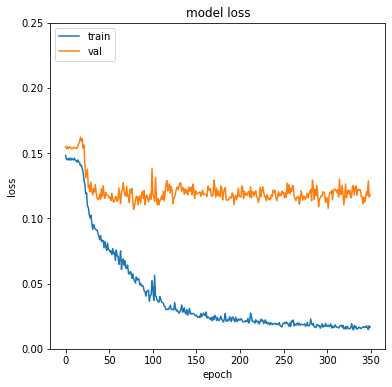

Cosine Similarity: 0.470085471868515



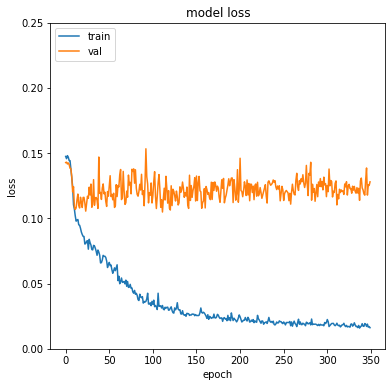

Cosine Similarity: 0.4444444477558136



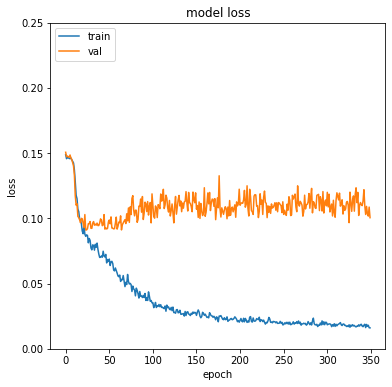

Cosine Similarity: 0.6068376302719116



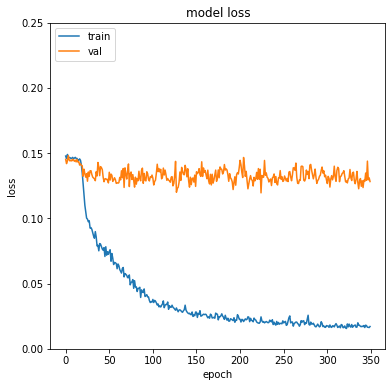

Cosine Similarity: 0.504273533821106



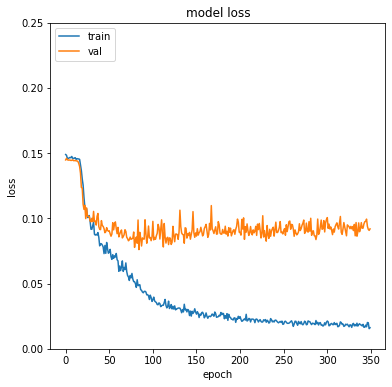

Cosine Similarity: 0.5897436141967773



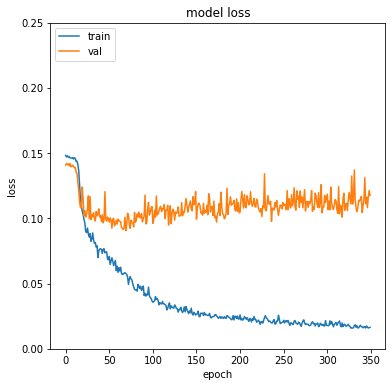

Cosine Similarity: 0.4568965435028076



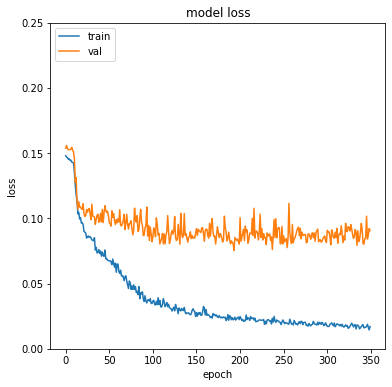

Cosine Similarity: 0.5258620977401733



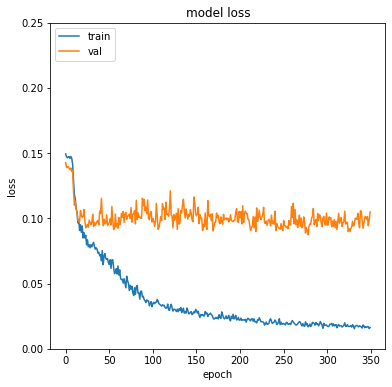

Cosine Similarity: 0.5775862336158752



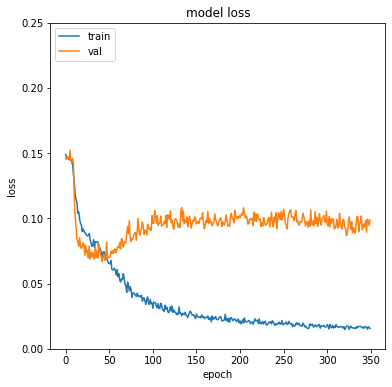

Cosine Similarity: 0.5043478012084961



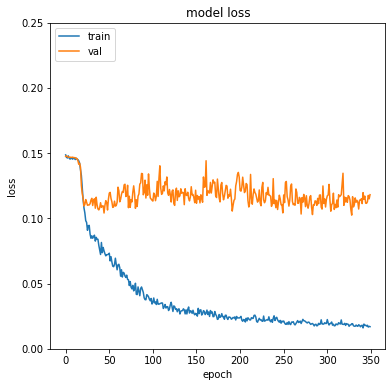

Cosine Similarity: 0.417391300201416

Time Elapsed: 4067.589341878891
Epochs: 350
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f69e2649ef0>
Dense Activation Function: relu
LSTM Nodes 1: 100
LSTM Nodes 2: 100
Hidden Nodes 1: 50
Hidden Nodes 2: 10
Input Noise Std: 0.1
Hidden Dropout Rate: 0.2
Stratified k-Fold Cosine Similarity Avg Score: 0.5097469091415405, Std Score: 0.061568841338157654


In [0]:
adam=tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
grid_model_W2V_lstm(df_train,input_noise=0.1,hidden_dropout=0.2,activation_list=['relu'],lstm_nodes_1=100,lstm_nodes_2=100,hidden_nodes_1=50,hidden_nodes_2=10,optimizer=adam,epochs=350,batch_size=32)

### Prediction

In [0]:
def model_W2V_lstm(df,df_test,input_noise,hidden_dropout,act,hidden_nodes_1,hidden_nodes_2,lstm_nodes_1,lstm_nodes_2,optimizer,epochs,batch_size=32):
  '''
  Function for prediction
  '''
  X_train=df['clean_text'].tolist()
  y_train=np.array(df['sentiment score'])
  X_test=df_test['clean_text'].tolist()
  y_test=np.array(df_test['sentiment score'])
  max_sequence_length = 50
  start=time()

  # prepare tokenizer
  t = Tokenizer()
  t.fit_on_texts(X_train)
  X_train = t.texts_to_sequences(X_train)
  X_test = t.texts_to_sequences(X_test)

  # Adding 1 because of reserved 0 index
  vocab_size = len(t.word_index) + 1

  X_train = pad_sequences(X_train, padding='post', maxlen=max_sequence_length)
  X_test = pad_sequences(X_test, padding='post', maxlen=max_sequence_length)

  embedding_size=300
  # create a weight matrix for words in training docs
  W2V_embedding_matrix = np.zeros((vocab_size, embedding_size))
  for word, i in t.word_index.items():
    if word in model_w2v:
      W2V_embedding_vector = model_w2v[word]
      W2V_embedding_matrix[i] = W2V_embedding_vector
      
  #Define LSTM
  sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
  embedding_layer = Embedding(vocab_size, embedding_size, weights=[W2V_embedding_matrix], input_length=max_sequence_length, trainable=False)
  embedded_sequences = embedding_layer(sequence_input)
  out=GaussianNoise(input_noise)(embedded_sequences)
  # out=LSTM(100,return_sequences=True,dropout=hidden_dropout,recurrent_dropout=hidden_dropout)(out)
  # out=LSTM(70,dropout=hidden_dropout,recurrent_dropout=hidden_dropout)(out)
  out=tf.keras.layers.CuDNNLSTM(lstm_nodes_1,return_sequences=True)(out)
  out=tf.keras.layers.CuDNNLSTM(lstm_nodes_2)(out)
  out = Dropout(hidden_dropout)(out)
  out = Dense(hidden_nodes_1,activation=act)(out)
  out = Dense(hidden_nodes_2,activation='tanh')(out)
  out = Dense(1)(out)
  model = Model(sequence_input,out)
  model.compile(loss='MSE', optimizer=optimizer, metrics=['cosine_proximity'])
  # print(model.summary())
  history=model.fit(X_train,y_train, batch_size=batch_size,epochs=epochs,verbose=False)
  pred_test=model.predict(X_test,batch_size=32)
  pred_test=pred_test.reshape(1,-1)
  end=time()
  print('Time Elapsed: {}'.format(end-start))
  print('Epochs: {}'.format(epochs))
  print('Optimizer: {}'.format(optimizer))
  print('Dense Activation Function: {}'.format(act))
  print('LSTM Nodes 1: {}'.format(lstm_nodes_1))
  print('LSTM Nodes 2: {}'.format(lstm_nodes_2))
  print('Hidden Nodes 1: {}'.format(hidden_nodes_1))
  print('Hidden Nodes 2: {}'.format(hidden_nodes_2))
  print('Input Noise Std: {}'.format(input_noise))
  print('Hidden Dropout Rate: {}'.format(hidden_dropout))
  print('Test Cosine Similarity Score:{}'.format(cosine_similarity(pred_test,y_test.reshape(1,-1))[0][0]))
  return(pd.Series(pred_test[0]))

In [0]:
adam=tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
pred_lstm_W2V=model_W2V_lstm(df_train,df_test,input_noise=0.1,hidden_dropout=0.2,act='relu',lstm_nodes_1=100,lstm_nodes_2=100,hidden_nodes_1=50,hidden_nodes_2=10,optimizer=adam,epochs=350,batch_size=32)

Time Elapsed: 448.67584681510925
Epochs: 350
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f69dca61630>
Dense Activation Function: relu
LSTM Nodes 1: 100
LSTM Nodes 2: 100
Hidden Nodes 1: 50
Hidden Nodes 2: 10
Input Noise Std: 0.1
Hidden Dropout Rate: 0.2
Test Cosine Similarity Score:0.6864050135526251


In [0]:
pd.DataFrame(pred_lstm_W2V,columns=['pred_lstm_W2V']).to_csv('pred_lstm_W2V.csv')

## GloVe

### Hyperparameter Tuning

In [0]:
def grid_model_GloVe_lstm(df,input_noise,hidden_dropout,activation_list,hidden_nodes_1,hidden_nodes_2,lstm_nodes_1,lstm_nodes_2,optimizer,epochs,batch_size=32):
  '''
  Function for hyperparameter tuning GloVe
  '''
  kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=500)
  X=df['clean_text']
  stratify=df['source']
  y=df['sentiment score']
  max_sequence_length = 50
  for act in activation_list:
    cvscores = []
    start=time()
    for train,val in kfold.split(X,stratify):
      X_train=X[train].tolist()
      y_train=np.array(y[train])
      X_val=X[val].tolist()
      y_val=np.array(y[val])

      # prepare tokenizer
      t = Tokenizer()
      t.fit_on_texts(X_train)
      X_train = t.texts_to_sequences(X_train)
      X_val = t.texts_to_sequences(X_val)

      # Adding 1 because of reserved 0 index
      vocab_size = len(t.word_index) + 1

      X_train = pad_sequences(X_train, padding='post', maxlen=max_sequence_length)
      X_val = pad_sequences(X_val, padding='post', maxlen=max_sequence_length)

      embedding_size=200
      # create a weight matrix for words in training docs
      GloVe_embedding_matrix = np.zeros((vocab_size, embedding_size))
      for word, i in t.word_index.items():
        if word in model_GloVe:
          GloVe_embedding_vector = model_GloVe[word]
          GloVe_embedding_matrix[i] = GloVe_embedding_vector
      
      #Define LSTM
      sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
      embedding_layer = Embedding(vocab_size, embedding_size, weights=[GloVe_embedding_matrix], input_length=max_sequence_length, trainable=False)
      embedded_sequences = embedding_layer(sequence_input)
      out=GaussianNoise(input_noise)(embedded_sequences)
      # out=LSTM(100,return_sequences=True,dropout=hidden_dropout,recurrent_dropout=hidden_dropout)(out)
      # out=LSTM(70,dropout=hidden_dropout,recurrent_dropout=hidden_dropout)(out)
      out=tf.keras.layers.CuDNNLSTM(lstm_nodes_1,return_sequences=True)(out)
      out=tf.keras.layers.CuDNNLSTM(lstm_nodes_2)(out)
      out = Dropout(hidden_dropout)(out)
      out = Dense(hidden_nodes_1,activation=act)(out)
      out = Dense(hidden_nodes_2,activation='tanh')(out)
      out = Dense(1)(out)
      model = Model(sequence_input,out)
      model.compile(loss='MSE', optimizer=optimizer, metrics=['cosine_proximity'])
      # print(model.summary())
      history=model.fit(X_train,y_train, batch_size=batch_size,epochs=epochs, validation_data=(X_val, y_val),verbose=False)
      plt.figure(figsize=(6,6))
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.ylim((0,0.25))
      plt.legend(['train', 'val'], loc='upper left')
      plt.show()
      loss, cos = model.evaluate(X_val, y_val, verbose=False)
      print('Cosine Similarity: {}\n'.format(cos))
      cvscores.append(cos)
    end=time()
    print('Time Elapsed: {}'.format(end-start))
    print('Epochs: {}'.format(epochs))
    print('Optimizer: {}'.format(optimizer))
    print('Dense Activation Function: {}'.format(act))
    print('LSTM Nodes 1: {}'.format(lstm_nodes_1))
    print('LSTM Nodes 2: {}'.format(lstm_nodes_2))
    print('Hidden Nodes 1: {}'.format(hidden_nodes_1))
    print('Hidden Nodes 2: {}'.format(hidden_nodes_2))
    print('Input Noise Std: {}'.format(input_noise))
    print('Hidden Dropout Rate: {}'.format(hidden_dropout))
    print('Stratified k-Fold Cosine Similarity Avg Score: {}, Std Score: {}'.format(np.mean(cvscores),np.std(cvscores)))

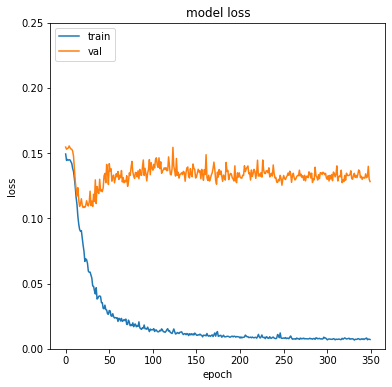

Cosine Similarity: 0.43589743971824646



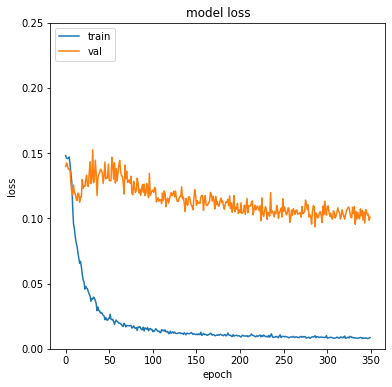

Cosine Similarity: 0.5299145579338074



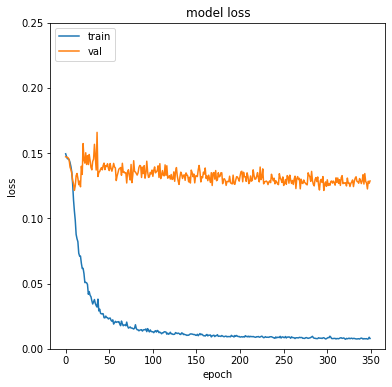

Cosine Similarity: 0.470085471868515



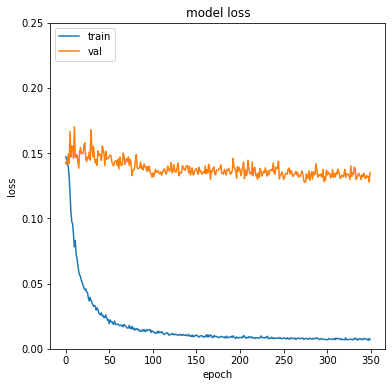

Cosine Similarity: 0.45299145579338074



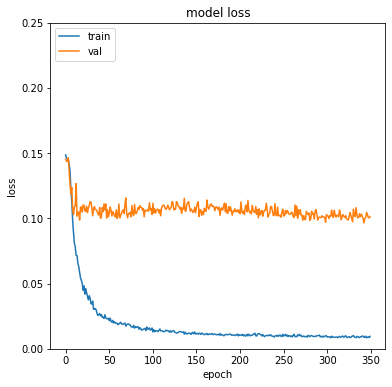

Cosine Similarity: 0.5555555820465088



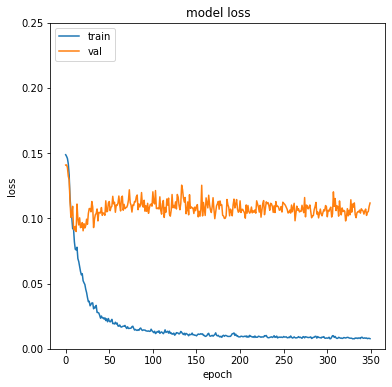

Cosine Similarity: 0.47413793206214905



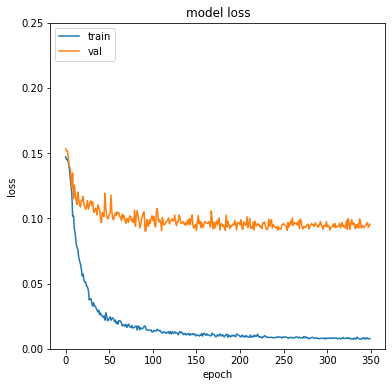

Cosine Similarity: 0.5603448152542114



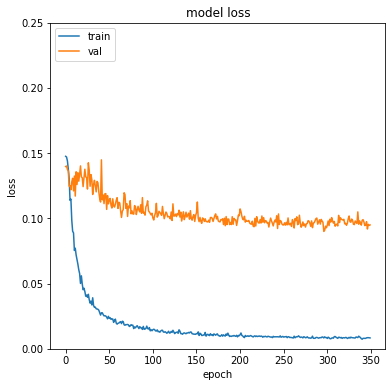

Cosine Similarity: 0.5086206793785095



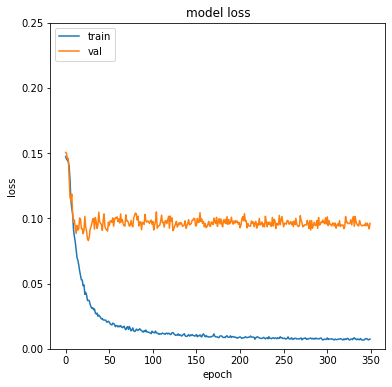

Cosine Similarity: 0.573913037776947



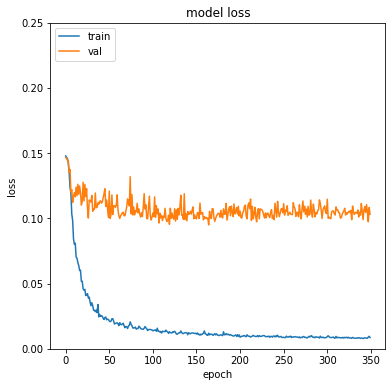

Cosine Similarity: 0.573913037776947

Time Elapsed: 4109.652528762817
Epochs: 350
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f69df202278>
Dense Activation Function: relu
LSTM Nodes 1: 100
LSTM Nodes 2: 100
Hidden Nodes 1: 50
Hidden Nodes 2: 10
Input Noise Std: 0.1
Hidden Dropout Rate: 0.2
Stratified k-Fold Cosine Similarity Avg Score: 0.5135374069213867, Std Score: 0.04967237263917923


In [0]:
adam=tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
grid_model_GloVe_lstm(df_train,input_noise=0.1,hidden_dropout=0.2,activation_list=['relu'],lstm_nodes_1=100,lstm_nodes_2=100,hidden_nodes_1=50,hidden_nodes_2=10,optimizer=adam,epochs=350,batch_size=32)

### Prediction

In [0]:
def model_GloVe_lstm(df,df_test,input_noise,hidden_dropout,act,hidden_nodes_1,hidden_nodes_2,lstm_nodes_1,lstm_nodes_2,optimizer,epochs,batch_size=32):
  '''
  Function for prediction
  '''
  X_train=df['clean_text'].tolist()
  y_train=np.array(df['sentiment score'])
  X_test=df_test['clean_text'].tolist()
  y_test=np.array(df_test['sentiment score'])
  max_sequence_length = 50
  start=time()

  # prepare tokenizer
  t = Tokenizer()
  t.fit_on_texts(X_train)
  X_train = t.texts_to_sequences(X_train)
  X_test = t.texts_to_sequences(X_test)

  # Adding 1 because of reserved 0 index
  vocab_size = len(t.word_index) + 1

  X_train = pad_sequences(X_train, padding='post', maxlen=max_sequence_length)
  X_test = pad_sequences(X_test, padding='post', maxlen=max_sequence_length)

  embedding_size=200
  # create a weight matrix for words in training docs
  GloVe_embedding_matrix = np.zeros((vocab_size, embedding_size))
  for word, i in t.word_index.items():
    if word in model_GloVe:
      GloVe_embedding_vector = model_GloVe[word]
      GloVe_embedding_matrix[i] = GloVe_embedding_vector
      
  #Define LSTM
  sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
  embedding_layer = Embedding(vocab_size, embedding_size, weights=[GloVe_embedding_matrix], input_length=max_sequence_length, trainable=False)
  embedded_sequences = embedding_layer(sequence_input)
  out=GaussianNoise(input_noise)(embedded_sequences)
  # out=LSTM(100,return_sequences=True,dropout=hidden_dropout,recurrent_dropout=hidden_dropout)(out)
  # out=LSTM(70,dropout=hidden_dropout,recurrent_dropout=hidden_dropout)(out)
  out=tf.keras.layers.CuDNNLSTM(lstm_nodes_1,return_sequences=True)(out)
  out=tf.keras.layers.CuDNNLSTM(lstm_nodes_2)(out)
  out = Dropout(hidden_dropout)(out)
  out = Dense(hidden_nodes_1,activation=act)(out)
  out = Dense(hidden_nodes_2,activation='tanh')(out)
  out = Dense(1)(out)
  model = Model(sequence_input,out)
  model.compile(loss='MSE', optimizer=optimizer, metrics=['cosine_proximity'])
  # print(model.summary())
  history=model.fit(X_train,y_train, batch_size=batch_size,epochs=epochs,verbose=False)
  pred_test=model.predict(X_test,batch_size=32)
  pred_test=pred_test.reshape(1,-1)
  end=time()
  print('Time Elapsed: {}'.format(end-start))
  print('Epochs: {}'.format(epochs))
  print('Optimizer: {}'.format(optimizer))
  print('Dense Activation Function: {}'.format(act))
  print('LSTM Nodes 1: {}'.format(lstm_nodes_1))
  print('LSTM Nodes 2: {}'.format(lstm_nodes_2))
  print('Hidden Nodes 1: {}'.format(hidden_nodes_1))
  print('Hidden Nodes 2: {}'.format(hidden_nodes_2))
  print('Input Noise Std: {}'.format(input_noise))
  print('Hidden Dropout Rate: {}'.format(hidden_dropout))
  print('Test Cosine Similarity Score:{}'.format(cosine_similarity(pred_test,y_test.reshape(1,-1))[0][0]))
  return(pd.Series(pred_test[0]))

In [0]:
adam=tensorflow.keras.optimizers.Adam(learning_rate=0.0001)
pred_lstm_GloVe=model_GloVe_lstm(df_train,df_test,input_noise=0.1,hidden_dropout=0.2,act='relu',lstm_nodes_1=100,lstm_nodes_2=100,hidden_nodes_1=50,hidden_nodes_2=10,optimizer=adam,epochs=350,batch_size=32)

Time Elapsed: 438.17187666893005
Epochs: 350
Optimizer: <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f69dd0923c8>
Dense Activation Function: relu
LSTM Nodes 1: 100
LSTM Nodes 2: 100
Hidden Nodes 1: 50
Hidden Nodes 2: 10
Input Noise Std: 0.1
Hidden Dropout Rate: 0.2
Test Cosine Similarity Score:0.6307029733156331


In [0]:
pd.DataFrame(pred_lstm_GloVe,columns=['pred_lstm_GloVe']).to_csv('pred_lstm_GloVe.csv')